<a href="https://colab.research.google.com/github/kollerbud/resume-rec/blob/main/Project%20new%20findings%20Risha%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries **

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import csv # Import the csv module
from sklearn.metrics.pairwise import cosine_similarity

# **Load the data sets **

In [2]:
# Load Resume Dataset
resume_df = pd.read_csv('Resume.csv')
resume_df= resume_df.rename(columns={'Resume_str': 'Resume'})
resume_df = resume_df.drop_duplicates(subset=['Resume'])
resume_df = resume_df.dropna(subset=['Resume'])
resume_df = resume_df.drop(columns=['Resume_html'])
# Load LinkedIn Job Postings Dataset
job_df = pd.read_csv('postings.csv')
#job_df['job_id'] = pd.to_numeric(job_df['job_id'], errors='coerce').astype('Int64') #Converting the job_id column in job_df to numeric, then to Int64 to handle missing values



# Additinal data

In [4]:
# Loading additional job data
job_jobskills = pd.read_csv("job_skills.csv").drop_duplicates(subset="job_id")
job_jobindustries = pd.read_csv("job_industries.csv").drop_duplicates(subset="job_id")

# Loading company data
job_specialties = pd.read_csv("company_specialities.csv").drop_duplicates(subset="company_id")
job_industries = pd.read_csv("company_industries.csv").drop_duplicates(subset="company_id")
job_companies = pd.read_csv("companies.csv").drop_duplicates(subset="company_id")

# Loading mappings
job_skillsmapping = pd.read_csv("skills.csv").drop_duplicates(subset="skill_abr")
job_industrymapping = pd.read_csv("industries.csv").drop_duplicates(subset="industry_id")


# Joining the data

In [5]:
temp_df = job_df \
    .merge(job_jobskills, on="job_id", how="left") \
    .merge(job_jobindustries, on="job_id", how="left") \
    .merge(job_specialties, on="company_id", how="left") \
    .merge(job_industries, on="company_id", how="left") \
    .merge(job_companies, on="company_id", how="left") \
    .merge(job_skillsmapping, on="skill_abr", how="left") \
    .merge(job_industrymapping, on="industry_id", how="left")

In [ ]:
temp_df.head()

,job_id,company_name,title,description_x,max_salary,pay_period,location,company_id,views,med_salary,...,description_y,company_size,state,country,city,zip_code_y,address,url,skill_name,industry_name
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,Marketing,Real Estate
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Health Care Provider,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,"In April of 1983, The National Exemplar began ...",1.0,Ohio,US,Mariemont,45227,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,Management,Restaurants
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,"Abrams Fensterman, LLP is a full-service law f...",2.0,New York,US,Lake Success,11042,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,Other,Law Practice
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Information Technology,Facilities Services


In [6]:
# Cleaning up temporary columns and renaming
temp_df['zip_code'] = temp_df['zip_code_x'].combine_first(temp_df['zip_code_y'])
temp_df = temp_df.rename(columns={'description_x': 'job_description', 'description_y': 'company_description'})
jobpost_df = temp_df.drop(columns=[
    'job_id', 'company_id', 'applies', 'original_listed_time', 'application_type', 'expiry',
    'closed_time', 'sponsored', 'fips', 'skill_abr', 'industry_id', 'zip_code_x', 'zip_code_y'
])

In [7]:
# Concatenate relevant columns to create a combined job posting field
jobpost_df['concat_posting'] = jobpost_df['title'] + " " + jobpost_df['job_description'] + " " + \
                               jobpost_df['skills_desc'] + " " + jobpost_df['skill_name'] + " " + \
                               jobpost_df['industry_name']

In [8]:
jobpost_df.head()

,company_name,title,job_description,max_salary,pay_period,location,views,med_salary,min_salary,formatted_work_type,...,company_size,state,country,city,address,url,skill_name,industry_name,zip_code,concat_posting
0,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",20.0,NaN,17.0,Full-time,...,2.0,NJ,US,Jersey City,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,Marketing,Real Estate,8540.0,Marketing Coordinator Job descriptionA leading...
1,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",1.0,NaN,30.0,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,Health Care Provider,NaN,80521.0,NaN
2,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",8.0,NaN,45000.0,Full-time,...,1.0,Ohio,US,Mariemont,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,Management,Restaurants,45202.0,Assitant Restaurant Manager The National Exemp...
3,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",16.0,NaN,140000.0,Full-time,...,2.0,New York,US,Lake Success,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,Other,Law Practice,11040.0,Senior Elder Law / Trusts and Estates Associat...
4,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",3.0,NaN,60000.0,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,Information Technology,Facilities Services,52601.0,NaN


# **Explore the data **

In [11]:
# Display the first few rows and column names for LinkedIn dataset
print("LinkedIn Job Postings Dataset:")
print(jobpost_df.head())
print(jobpost_df.info())
print(jobpost_df.describe())

# Display the first few rows and column names for Resume dataset
print("\nResume Dataset:")
print(resume_df.head())
print(resume_df.info())
print(resume_df.describe())


LinkedIn Job Postings Dataset:
             company_name                                              title  \
0   Corcoran Sawyer Smith                              Marketing Coordinator   
1                     NaN                  Mental Health Therapist/Counselor   
2  The National Exemplar                         Assitant Restaurant Manager   
3  Abrams Fensterman, LLP  Senior Elder Law / Trusts and Estates Associat...   
4                     NaN                                 Service Technician   

                                     job_description  max_salary pay_period  \
0  Job descriptionA leading real estate firm in N...        20.0     HOURLY   
1  At Aspen Therapy and Wellness , we are committ...        50.0     HOURLY   
2  The National Exemplar is accepting application...     65000.0     YEARLY   
3  Senior Associate Attorney - Elder Law / Trusts...    175000.0     YEARLY   
4  Looking for HVAC service tech with experience ...     80000.0     YEARLY   

            l

# **Data cleaning ** Linedln job dataset

In [12]:
def clean_text(txt):
    cleanText = re.sub('http\S+\s*', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+', '', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]',r' ', cleanText)
    cleanText = re.sub('\s+', ' ', cleanText)
    cleanText=re.sub(r'\s+', ' ', cleanText)
    cleanText=re.sub(r'[^\w\s]', '', cleanText)
    cleanText=re.sub(r'[\r\n\t]', ' ', cleanText)

    cleanText = re.sub('ï»¿', '', cleanText)



    return cleanText

In [13]:
resume_df['Resume'] = resume_df['Resume'].apply(clean_text)
# Convert the column to string type and fill NaN with an empty string
jobpost_df['concat_posting'] = jobpost_df['concat_posting'].astype(str).fillna("")

jobpost_df['concat_posting'] = jobpost_df['concat_posting'].apply(clean_text)

In [14]:

# Tokenize the cleaned resume and job posting text
resume_tokens = resume_df['Resume'].apply(lambda x: x.split())
jobpost_tokens = jobpost_df['concat_posting'].apply(lambda x: x.split())

In [15]:
# Preview the tokens
print("Resume Tokens Sample:", resume_tokens.head())
print("Job Post Tokens Sample:", jobpost_tokens.head())


Resume Tokens Sample: 0    [HR, ADMINISTRATOR, MARKETING, ASSOCIATE, HR, ...
1    [HR, SPECIALIST, US, HR, OPERATIONS, Summary, ...
2    [HR, DIRECTOR, Summary, Over, 20, years, exper...
3    [HR, SPECIALIST, Summary, Dedicated, Driven, a...
4    [HR, MANAGER, Skill, Highlights, HR, SKILLS, H...
Name: Resume, dtype: object
Job Post Tokens Sample: 0    [Marketing, Coordinator, Job, descriptionA, le...
1                                                [nan]
2    [Assitant, Restaurant, Manager, The, National,...
3    [Senior, Elder, Law, Trusts, and, Estates, Ass...
4                                                [nan]
Name: concat_posting, dtype: object


In [16]:

# Step 1: Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)





In [17]:
# Step 2: Combine both Resume and Job Posting text for a common TF-IDF vocabulary
combined_text = pd.concat([resume_df['Resume'], jobpost_df['concat_posting']], axis=0)


In [18]:
# Step 3: Fit the TF-IDF Vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)


In [19]:
# Step 4: Split TF-IDF Matrix for Resumes and Job Postings
resume_tfidf = tfidf_matrix[:len(resume_df)]
jobpost_tfidf = tfidf_matrix[len(resume_df):]


In [20]:
# Convert TF-IDF matrices to DataFrames for easier inspection
resume_tfidf_df = pd.DataFrame(resume_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
jobpost_tfidf_df = pd.DataFrame(jobpost_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [21]:
# Display a sample of the TF-IDF features
print("TF-IDF Features for Resumes:")
print(resume_tfidf_df.head())


TF-IDF Features for Resumes:
    00  000        01        02        03        04        05        06   07  \
0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1  0.0  0.0  0.060893  0.000000  0.000000  0.000000  0.032203  0.000000  0.0   
2  0.0  0.0  0.000000  0.027616  0.027642  0.027057  0.053642  0.026631  0.0   
3  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

    08  ...    worked  workers   working  works  world  writing   written  \
0  0.0  ...  0.000000  0.00000  0.049818    0.0    0.0      0.0  0.000000   
1  0.0  ...  0.000000  0.00000  0.000000    0.0    0.0      0.0  0.000000   
2  0.0  ...  0.000000  0.02738  0.065096    0.0    0.0      0.0  0.000000   
3  0.0  ...  0.000000  0.00000  0.000000    0.0    0.0      0.0  0.048343   
4  0.0  ...  0.016068  0.00000  0.000000    0.0    0.0      0.0  0.000000   

       year     years  yout

In [22]:

print("\nTF-IDF Features for Job Postings:")
print(jobpost_tfidf_df.head())


TF-IDF Features for Job Postings:
    00       000   01   02   03   04   05   06   07   08  ...  worked  \
0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
1  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
2  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
3  0.0  0.058181  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
4  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

   workers   working  works  world  writing   written      year     years  \
0      0.0  0.083318    0.0    0.0      0.0  0.000000  0.044258  0.039661   
1      0.0  0.000000    0.0    0.0      0.0  0.000000  0.000000  0.000000   
2      0.0  0.000000    0.0    0.0      0.0  0.000000  0.000000  0.176413   
3      0.0  0.000000    0.0    0.0      0.0  0.112692  0.000000  0.047623   
4      0.0  0.000000    0.0    0.0      0.0  0.000000  0.000000  0.000000   

   youth  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

# Visulization

In [23]:
pip install wordcloud matplotlib

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

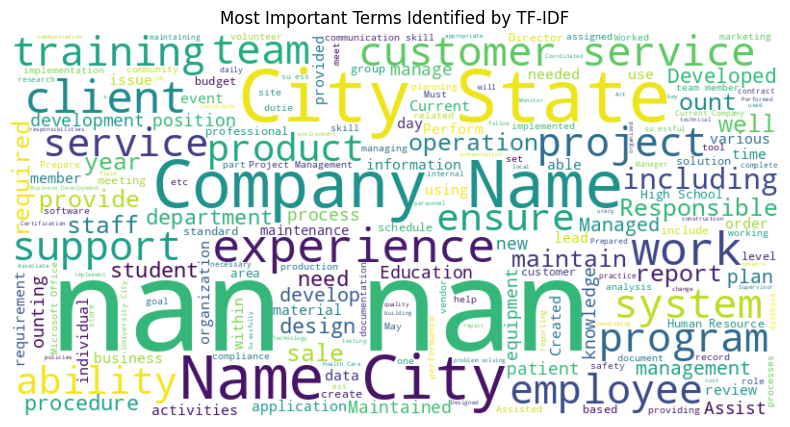

In [25]:
# Combine all text data for word cloud (resumes + job postings)
all_text = ' '.join(resume_df['Resume']) + ' ' + ' '.join(jobpost_df['concat_posting'])

# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Important Terms Identified by TF-IDF")
plt.show()

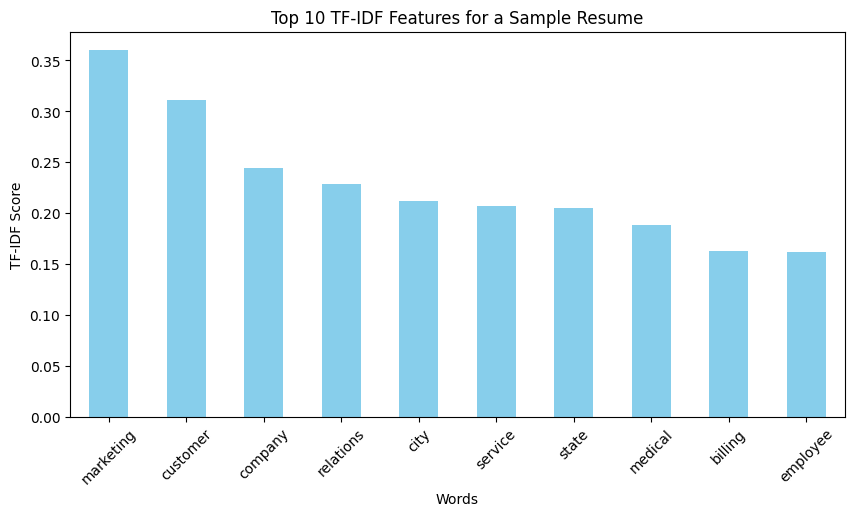

In [26]:
# Get the top 10 features (words) with the highest TF-IDF scores from a sample resume
tfidf_scores = resume_tfidf_df.iloc[0].sort_values(ascending=False).head(10)

# Create a Bar Chart
plt.figure(figsize=(10, 5))
tfidf_scores.plot(kind='bar', color='skyblue')
plt.title("Top 10 TF-IDF Features for a Sample Resume")
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=45)
plt.show()

In [27]:
# Replace NaN values in job postings with an empty string
jobpost_df.fillna("", inplace=True)

# Re-apply text cleaning after handling NaN values
jobpost_df['concat_posting'] = jobpost_df['concat_posting'].apply(clean_text)


<ipython-input-27-a22b53f5a437>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  jobpost_df.fillna("", inplace=True)


In [29]:


# Load the testing datasets
test_resumes_id = pd.read_csv('test_resume_id.csv')
test_jobs = pd.read_csv('testset_job_id.csv')

# Rename columns for consistency
test_resumes = test_resumes.rename(columns={'Resume_str': 'Resume'})
test_resumes = test_resumes.dropna(subset=['Resume'])
test_jobs = test_jobs.dropna(subset=['Job Description'])

# Handle NaN values by filling with an empty string
test_resumes['Resume'] = test_resumes['Resume'].fillna("")
test_jobs['Job Description'] = test_jobs['Job Description'].fillna("")

# Define the text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabet characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

# Apply text cleaning and handle NaN values again
test_resumes['Resume'] = test_resumes['Resume'].apply(clean_text)
test_jobs['Job Description'] = test_jobs['Job Description'].apply(clean_text)

# Drop any remaining rows with empty strings after cleaning
test_resumes = test_resumes[test_resumes['Resume'] != ""]
test_jobs = test_jobs[test_jobs['Job Description'] != ""]

print(f"Cleaned test resumes: {len(test_resumes)}")
print(f"Cleaned test job descriptions: {len(test_jobs)}")


KeyError: ['Resume']

In [33]:
# Load the testing datasets for resume
test_resumes_id = pd.read_csv('test_resume_id.csv')
test_resumes = pd.merge(test_resumes_id, resume_df, left_on='ID', right_on='ID', how='left')
# Check the merged result
print("Merged Test Resumes:")
print(test_resumes.head())


Merged Test Resumes:
         ID                                             Resume      Category
0  71576860   CONCRETE CONSTRUCTION Summary A highly experi...  CONSTRUCTION
1  36331163   CONSTRUCTION MANAGER Summary Construction Mas...  CONSTRUCTION
2  15564893   CONSTRUCTION HELPER Summary Hardworking and E...  CONSTRUCTION
3  28942221   CONSTRUCTION INSPECTOR Professional Summary C...  CONSTRUCTION
4  13907230   GENERAL CONSTRUCTION INTERN Objective Dedicat...  CONSTRUCTION


In [34]:
# Handle NaN values and apply text cleaning
test_resumes['Resume'] = test_resumes['Resume'].fillna("").apply(clean_text)

# Drop any remaining rows with empty resumes after cleaning
test_resumes = test_resumes[test_resumes['Resume'] != ""]
print(f"Number of test resumes after cleaning: {len(test_resumes)}")


Number of test resumes after cleaning: 506


In [35]:
# Transform the test resumes using the fitted TF-IDF vectorizer
test_resumes_tfidf = tfidf_vectorizer.transform(test_resumes['Resume'])

# Convert the TF-IDF matrix to a DataFrame for easier inspection
test_resumes_tfidf_df = pd.DataFrame(test_resumes_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display a sample of the TF-IDF features
print("Sample of Testing TF-IDF Features (Resumes):")
print(test_resumes_tfidf_df.head())


Sample of Testing TF-IDF Features (Resumes):
    00  000        01   02        03        04   05        06   07        08  \
0  0.0  0.0  0.208492  0.0  0.037879  0.000000  0.0  0.000000  0.0  0.000000   
1  0.0  0.0  0.217415  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
2  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
3  0.0  0.0  0.034589  0.0  0.000000  0.073813  0.0  0.036327  0.0  0.144425   
4  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000   

   ...    worked   workers   working     works  world  writing   written  \
0  ...  0.000000  0.000000  0.000000  0.000000    0.0  0.00000  0.033494   
1  ...  0.000000  0.046951  0.037209  0.094651    0.0  0.00000  0.000000   
2  ...  0.025317  0.000000  0.000000  0.000000    0.0  0.02759  0.000000   
3  ...  0.000000  0.000000  0.000000  0.000000    0.0  0.00000  0.000000   
4  ...  0.000000  0.000000  0.000000  0.000000    0.0  0.00000  0.000000   

       year     y

In [36]:
# Save the TF-IDF features to a CSV file
test_resumes_tfidf_df.to_csv('test_resumes_tfidf_clean.csv', index=False)
print("Cleaned and transformed TF-IDF features for test resumes have been saved.")


Cleaned and transformed TF-IDF features for test resumes have been saved.


In [39]:
# Load the job postings dataset and the test job IDs
jobpost_df = pd.read_csv('postings.csv')
test_jobs_ids = pd.read_csv('testset_job_id.csv')

# Merge the test job IDs with the main job postings dataset
test_jobs = pd.merge(test_jobs_ids, jobpost_df, left_on='job_id', right_on='job_id', how='left')

# Handle NaN values and apply text cleaning
test_jobs['Job Description'] = test_jobs['description'].fillna("").apply(clean_text)

# Drop any remaining rows with empty job descriptions
test_jobs = test_jobs[test_jobs['Job Description'] != ""]
print(f"Number of test job descriptions after cleaning: {len(test_jobs)}")


Number of test job descriptions after cleaning: 21350


In [40]:
# Transform the test job descriptions using the fitted TF-IDF vectorizer
test_jobs_tfidf = tfidf_vectorizer.transform(test_jobs['Job Description'])

# Convert the TF-IDF matrix to a DataFrame
test_jobs_tfidf_df = pd.DataFrame(test_jobs_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display a sample of the transformed TF-IDF features
print("Sample of Testing TF-IDF Features (Job Descriptions):")
print(test_jobs_tfidf_df.head())


Sample of Testing TF-IDF Features (Job Descriptions):
         00       000   01   02   03   04   05   06   07   08  ...  worked  \
0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
1  0.055739  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
2  0.000000  0.171044  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
3  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
4  0.000000  0.083300  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

   workers   working  works  world  writing   written  year     years  youth  
0      0.0  0.000000    0.0    0.0      0.0  0.078355   0.0  0.066225    0.0  
1      0.0  0.000000    0.0    0.0      0.0  0.045975   0.0  0.038857    0.0  
2      0.0  0.073529    0.0    0.0      0.0  0.000000   0.0  0.000000    0.0  
3      0.0  0.000000    0.0    0.0      0.0  0.000000   0.0  0.000000    0.0  
4      0.0  0.000000    0.0    0.0      0.0  0.080672   0.0  0.068183    0.0  

[5

In [41]:
# Save the TF-IDF features for test job descriptions
test_jobs_tfidf_df.to_csv('test_jobs_tfidf_clean.csv', index=False)
print("Cleaned and transformed TF-IDF features for test job descriptions have been saved.")


Cleaned and transformed TF-IDF features for test job descriptions have been saved.


In [42]:
# Check for any missing values in the TF-IDF DataFrames
print(test_resumes_tfidf_df.isnull().sum().sum())
print(test_jobs_tfidf_df.isnull().sum().sum())


0
0
